In [64]:
import calendar
import math
from river import compose
from river import linear_model
from river import optim
from river import preprocessing
from river import time_series
from sklearn.model_selection import train_test_split
import pandas as pd
from river import neighbors

from river import metrics



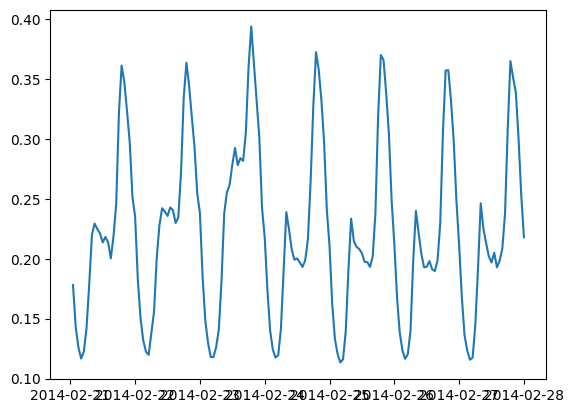

In [65]:

# Assuming df is your DataFrame and 'MeanEnergyConsumption' is your target variable
df = pd.read_csv('merged_data.csv')
df['DateTime'] = pd.to_datetime(df['DateTime'])

#take out a snipit of the data for testing that is one week long from the end of the data
test_data = df[df['DateTime'] > df['DateTime'].max() - pd.Timedelta(days=7)]




#get date range 
start_date = df["DateTime"].min()
end_date = df['DateTime'].max()

X = df.drop('MeanEnergyConsumption', axis=1)
y = df['MeanEnergyConsumption']

# Get month and day of the week from the date time column
X['Month'] = X['DateTime'].dt.month
X['DayOfWeek'] = X['DateTime'].dt.dayofweek



X_train = X
y_train = y

# Convert the training set back to DataFrame for the model training
train_df = pd.concat([X_train, y_train], axis=1)

#plot the data
import matplotlib.pyplot as plt
#plt.plot(train_df['DateTime'],train_df['MeanEnergyConsumption'])


#plot the last week of data
last_week = train_df[train_df['DateTime'] > end_date - pd.Timedelta(days=7)]
plt.plot(last_week['DateTime'],last_week['MeanEnergyConsumption'])


In [66]:
model_with_exog = (
    preprocessing.StandardScaler() |
    time_series.SNARIMAX(
        p=1,
        d=0,
        q=1,
        sp=0,
        sd=1,
        sq=1,
        m=24,
        regressor=(
            preprocessing.StandardScaler() |
            linear_model.LinearRegression(
                intercept_init=110,
                optimizer=optim.SGD(0.01),
                intercept_lr=0.3
            )
        )
    )
)

model_without_exog = (
    time_series.SNARIMAX(
        p=1,
        d=0,
        q=1,
        sp=0,
        sd=1,
        sq=1,
        m=24
    )
)


In [67]:
# Initialize the MAE metric
mae_with_exog = metrics.MAE()
mae_without_exog = metrics.MAE()

# Train the model without exogenous data
for i, (_, row) in enumerate(train_df.iterrows()):
    y = row['MeanEnergyConsumption']
    model_without_exog.learn_one(y)
    if i > 0:  # Skip the first observation
        forecast = model_without_exog.forecast(horizon=1)  # forecast 1 step ahead
        mae_without_exog.update(y, forecast[0])

print(f"One-step-ahead MAE without exogenous data: {mae_without_exog.get()}")

# Train the model with exogenous data
for i, (_, row) in enumerate(train_df.iterrows()):
    y = row['MeanEnergyConsumption']
    exog = row.drop('MeanEnergyConsumption').drop('DateTime').to_dict()
    model_with_exog.learn_one(exog, y)
    if i > 0:  # Skip the first observation
        forecast = model_with_exog.forecast(horizon=1, xs=[exog])  # forecast 1 step ahead
        mae_with_exog.update(y, forecast[0])

print(f"One-step-ahead MAE with exogenous data: {mae_with_exog.get()}")



One-step-ahead MAE without exogenous data: 0.02196715073869844
One-step-ahead MAE with exogenous data: 147769610053162.2


In [73]:
from river import evaluate
from river import optim
from river import metrics

# Define the parameter grid
param_grid = {
    'p': [1, 2, 3],
    'd': [0, 1],
    'q': [1, 2, 3],
    'sp': [0, 1],
    'sd': [1, 2],
    'sq': [1, 2],
    'm': [24],
    'regressor': [
        (preprocessing.StandardScaler() | linear_model.LinearRegression(intercept_lr=lr)) 
        for lr in [0.01, 0.1, 1.0]
    ]
}

# Initialize the model
model = (
    preprocessing.StandardScaler() |
    time_series.SNARIMAX()
)

# Initialize the grid search
grid_search = optim.GridSearch(
    model=model,
    param_grid=param_grid,
    metric=metrics.MAE(),
    print_every=50  # print every 50 iterations
)

# Run the grid search
grid_search.learn_many(train_df.drop('DateTime', axis=1), target_name='MeanEnergyConsumption')

# Print the best parameters and the best score
print(f"Best parameters: {grid_search.best_params}")
print(f"Best MAE: {grid_search.best_score}")

TypeError: SNARIMAX.__init__() missing 3 required positional arguments: 'p', 'd', and 'q'

In [68]:
# Initialize the MAE metric
mae = metrics.MAE()

# Train the model
list_of_predictions = []
for i, (_, row) in enumerate(train_df.iterrows()):
    y = row['MeanEnergyConsumption']
    exog = row.drop('MeanEnergyConsumption').drop('DateTime').to_dict()
    model.learn_one(exog, y)
    if i > 0:  # Skip the first observation
        forecast = model.forecast(horizon=1, xs=[exog])  # forecast 1 step ahead
        list_of_predictions.append(forecast[0])
        mae.update(y, forecast[0])

print(f"One-step-ahead MAE: {mae.get()}")



One-step-ahead MAE: 0.0230504425694691


In [69]:
# Forecast the next week
exog_next_week = df.iloc[:24*7].drop(['MeanEnergyConsumption', 'DateTime'], axis=1).to_dict('records')
forecast = model.forecast(horizon=24*7, xs=exog_next_week)

for t, y_pred in zip(range(len(forecast)), forecast):
    print(f'{t}: {y_pred:.3f}')

0: 0.167
1: 0.137
2: 0.127
3: 0.121
4: 0.120
5: 0.142
6: 0.186
7: 0.243
8: 0.225
9: 0.210
10: 0.198
11: 0.197
12: 0.202
13: 0.192
14: 0.197
15: 0.208
16: 0.237
17: 0.308
18: 0.363
19: 0.351
20: 0.339
21: 0.299
22: 0.251
23: 0.220
24: 0.173
25: 0.135
26: 0.128
27: 0.121
28: 0.119
29: 0.140
30: 0.185
31: 0.242
32: 0.221
33: 0.206
34: 0.195
35: 0.193
36: 0.198
37: 0.189
38: 0.193
39: 0.207
40: 0.237
41: 0.308
42: 0.361
43: 0.347
44: 0.335
45: 0.297
46: 0.252
47: 0.220
48: 0.175
49: 0.137
50: 0.128
51: 0.123
52: 0.114
53: 0.136
54: 0.184
55: 0.250
56: 0.221
57: 0.205
58: 0.194
59: 0.193
60: 0.196
61: 0.187
62: 0.193
63: 0.209
64: 0.238
65: 0.308
66: 0.360
67: 0.350
68: 0.336
69: 0.295
70: 0.250
71: 0.228
72: 0.182
73: 0.135
74: 0.127
75: 0.124
76: 0.115
77: 0.132
78: 0.179
79: 0.250
80: 0.221
81: 0.205
82: 0.194
83: 0.193
84: 0.196
85: 0.187
86: 0.195
87: 0.211
88: 0.237
89: 0.310
90: 0.359
91: 0.349
92: 0.335
93: 0.293
94: 0.249
95: 0.229
96: 0.183
97: 0.133
98: 0.126
99: 0.122
100: 0.112

In [70]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
# Plot the actual values
print(len(list_of_predictions))
print(len(train_df['MeanEnergyConsumption']))

#remove the first item of train df
train_df = train_df.iloc[1:]

print(len(list_of_predictions))
print(len(train_df['MeanEnergyConsumption']))

timestamps = pd.date_range(start=start_date, end=end_date, freq='1h')

print(len(timestamps))
#remove the first timestamp
timestamps = timestamps[1:]
print(len(timestamps))


19863
19864
19863
19863
19864
19863


C:\Users\Stijn\AppData\Local\Temp\ipykernel_125032\2624767574.py:5: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  ax.plot_date(mdates.date2num(timestamps), train_df['MeanEnergyConsumption'], linestyle='-', marker=None, alpha=0.5, label='Actual Values')
C:\Users\Stijn\AppData\Local\Temp\ipykernel_125032\2624767574.py:6: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  ax.plot_date(mdates.date2num(timestamps), list_of_predictions, linestyle='-', marker=None, alpha=0.5, label='Predictions')


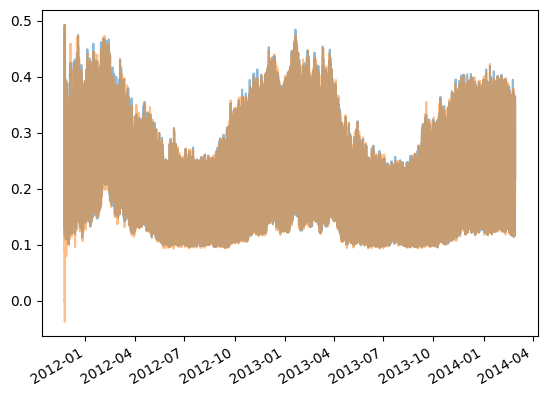

In [71]:
#plot the predictions


fig, ax = plt.subplots()
ax.plot_date(mdates.date2num(timestamps), train_df['MeanEnergyConsumption'], linestyle='-', marker=None, alpha=0.5, label='Actual Values')
ax.plot_date(mdates.date2num(timestamps), list_of_predictions, linestyle='-', marker=None, alpha=0.5, label='Predictions')
#rotate x axis labels
fig.autofmt_xdate()

             DateTime  temperature_2m  precipitation  cloud_cover  \
1 2011-11-23 10:00:00            6.80            0.0    30.600000   
2 2011-11-23 11:00:00            8.35            0.0    31.800000   
3 2011-11-23 12:00:00            9.45            0.0    35.400000   
4 2011-11-23 13:00:00           10.10            0.0    53.400000   
5 2011-11-23 14:00:00           10.25            0.0    69.899994   

   cloud_cover_low  cloud_cover_mid  cloud_cover_high  is_day  \
1              1.0              0.0              99.0     1.0   
2              3.0              0.0              97.0     1.0   
3              6.0              0.0             100.0     1.0   
4             26.0              0.0             100.0     1.0   
5             44.0              1.0              99.0     1.0   

   sunshine_duration  Month  DayOfWeek  MeanEnergyConsumption  
1          3600.0000     11          2               0.174500  
2          3600.0000     11          2               0.134000  
3 

C:\Users\Stijn\AppData\Local\Temp\ipykernel_125032\1548946292.py:19: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  plt.plot(pd.date_range(start='2014-02-21 00:00:00', periods=168, freq='H'), forecast, label='Forecast')


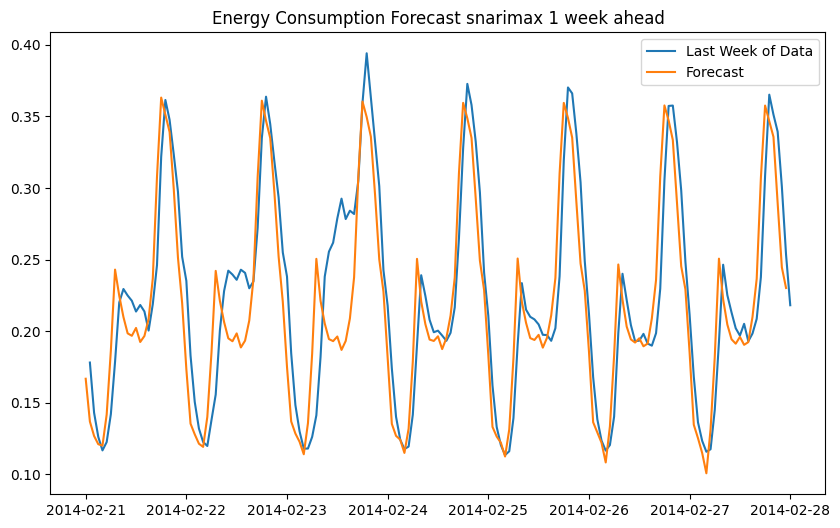

In [72]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
#plt.plot(train_df[-24*7:], label='Actual')
print(train_df.head())
#set start date for forecast

#only keep the last week of data from the forecast
end_date = '2014-02-21 00:00:00'
#convert end date to datetime
end_date = pd.to_datetime(end_date)
print(end_date)



#plot the actual values
#lt.plot(last_week['DateTime'],last_week['MeanEnergyConsumption'] ,label='Actual')
plt.plot(test_data['DateTime'],test_data['MeanEnergyConsumption'] ,label='Last Week of Data')
plt.plot(pd.date_range(start='2014-02-21 00:00:00', periods=168, freq='H'), forecast, label='Forecast')

plt.legend()
#set title
plt.title('Energy Consumption Forecast snarimax 1 week ahead')
plt.show()


